# Group Analysis of Diffusion MRI Data using Tract Base Spatial Statistics (TBSS)

FSLwiki: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TBSS. 

So far, we have worked through the steps required to pre-process a typical diffusion-weighted dataset, followed by model fitting. Next, we will focus on running TBSS to compare FA values between two groups of participants.

For this tutorial we will use a small dataset – 10 young pariticipants in their 20s, and 10 older participants in their 70s. We will attempt to find whether there are any FA differences between the two groups.

FA maps have already been computed for all participants, using the pre-rpocessing and model fitting steps discussed in previous tutorials.

TBSS consists of four steps, followed by statistical inference using non-parametric testing. Before we get started, lets first check the data. We will do this by running and FSL command, slicesdir, which generate an html file displaying a few slices for each of the FA maps, allowing for a quick inspection and quality control of the data.  

In [1]:
#import general modules
import os
import subprocess

#set up paths
scripts_dir = os.getcwd()
tbss_dir = f"{scripts_dir[0:61]}/data/GroupAnalysis/tbss"

#check if the origdata folder exists within the tbss directory, which would suggest that the tbss_1_preproc script has been run 
orig_path = f"{tbss_dir}/origdata"

if not os.path.exists(orig_path):
    #list of files in tbss directory
    for item in os.listdir(tbss_dir):
        print(item)
else:
    #list the files in the origdata directory
    for item in os.listdir(orig_path):
        print(item)

OLD_dti_fa_sub-CC610052.nii.gz
OLD_dti_fa_sub-CC610210.nii.gz
OLD_dti_fa_sub-CC610212.nii.gz
OLD_dti_fa_sub-CC610227.nii.gz
OLD_dti_fa_sub-CC610392.nii.gz
OLD_dti_fa_sub-CC610568.nii.gz
OLD_dti_fa_sub-CC610658.nii.gz
OLD_dti_fa_sub-CC620114.nii.gz
OLD_dti_fa_sub-CC620354.nii.gz
OLD_dti_fa_sub-CC620557.nii.gz
YNG_dti_fa_sub-CC110411.nii.gz
YNG_dti_fa_sub-CC120065.nii.gz
YNG_dti_fa_sub-CC120208.nii.gz
YNG_dti_fa_sub-CC120286.nii.gz
YNG_dti_fa_sub-CC120319.nii.gz
YNG_dti_fa_sub-CC120727.nii.gz
YNG_dti_fa_sub-CC120795.nii.gz
YNG_dti_fa_sub-CC120816.nii.gz
YNG_dti_fa_sub-CC121144.nii.gz
YNG_dti_fa_sub-CC121200.nii.gz


In [2]:
#change to tbss directory
os.chdir(tbss_dir)

#check if a slicesdir folder exists within the tbss directory, which would suggest that the slicesdir command has been run
slicesdir_path = f"{tbss_dir}/slicesdir"

#if slicesdir has not been run, run it to inspect the FA data
if not os.path.exists(slicesdir_path):

    #set up the command
    command = f"module load fsl; slicesdir *.nii.gz"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        html_file = [f for f in os.listdir(f"{tbss_dir}/slicesdir") if f.endswith('.html')]
        print(f"slicesdir completed successfully. To visualise the output, open the following link in your browser: http://{tbss_dir}/slicesdir/{html_file[0]}")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)



## Step 1 - TBSS pre-processing

The first TBSS script, tbss_1_preproc, will erode your FA images slightly to remove brain-edge artifacts and zero the end slices (again to remove likely outliers from the diffusion tensor fitting).


In [3]:
#run tbss_1_preproc

#change to tbss directory
os.chdir(tbss_dir)

#check if the origdata folder exists within the tbss directory, which would suggest that the tbss_1_preproc script has been run 
orig_path = f"{tbss_dir}/origdata"

#if the origdata folder does not exist, run tbss_1_preproc
if not os.path.exists(orig_path):
    
    #set up the command
    command = f"module load fsl; tbss_1_preproc *.nii.gz"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('tbss_1_preproc completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)


LOOK AT YOUR DATA

Check the images created in the FA directory. The tbss_1_preproc script will have re-run slicesdir on the preprocessed FA maps - open this report (you can find it in FA/slicesdir/index.html) and compare it to the slicesdir report you created earlier.


## Step 2 - Template registration

The next TBSS script runs the nonlinear registration, aligning all the FA data across subjects. The recommended approach is to align every FA image to the FMRIB58_FA template. This process can take a long time, as each registration takes around 10 minutes. This can be sped up if you have access to a server running cluster software such as SGE (Sun Grid Engine). 


In [4]:
#run tbss_2_reg

#change to tbss directory
os.chdir(tbss_dir)

#check if the target.nii.gz file exists within the tbss/FA directory, which would suggest that the tbss_2_reg script has been run 
target_file_path = f"{tbss_dir}/FA/target.nii.gz"

#if the target file does not exist, run tbss_2_reg
if not os.path.exists(target_file_path):

    #set up the command
    command = f"module load fsl; tbss_2_reg -T"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('tbss_2_reg completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

## Step 3 - Post-registration processing

The previous script (tbss_2_reg) only got as far as registering all subjects to the chosen template. The tbss_3_postreg script applies these registrations to take all subjects into 1x1x1mm standard space.

This script also merges all of the subjects' standard space nonlinearly aligned images into a single 4D image file called all_FA, created in a new subdirectory called stats. The mean of all FA images is created, called mean_FA, and this is then fed into the FA skeletonisation program to create mean_FA_skeleton. 


In [5]:
#run tbss_3_postreg

#change to tbss directory
os.chdir(tbss_dir)

#check if the mean_FA_skeleton.nii.gz file exists within the tbss/stats directory, which would suggest that the tbss_3_postreg script has been run 
ske_file_path = f"{tbss_dir}/stats/mean_FA_skeleton.nii.gz"

#if the skeleton file does not exist, run tbss_3_postreg
if not os.path.exists(ske_file_path):

    #set up the command
    command = f"module load fsl; tbss_3_postreg -S"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('tbss_3_postreg completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

Once the script has finished running, check that the mean FA image looks reasonable, and is well aligned with the MNI152 image: 

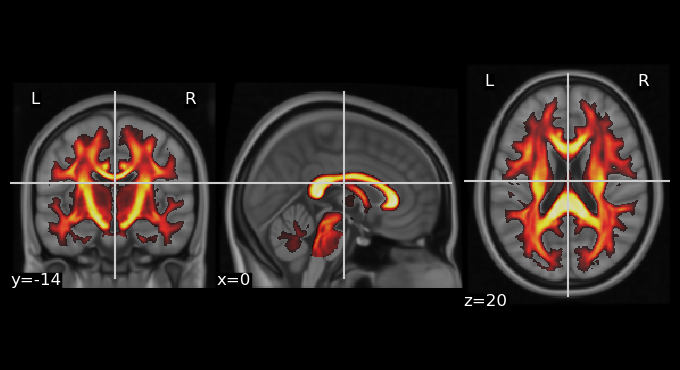

In [6]:
#import modules for visualisation
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting, image
from nilearn.image import load_img

#path to FSLDIR
fsldir_path = os.environ.get('FSLDIR')

# Load the images
background_img = load_img(f"{fsldir_path}/data/standard/MNI152_T1_1mm.nii.gz")
overlay_img = load_img(f"{tbss_dir}/stats/mean_FA.nii.gz")

#theshold the mean FA image to show only values between 0.2 and 0.9 for display purposes
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.2) & (data <= 0.9), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

# Show the plot
plt.show()

The mean FA image is indeed well aligned to standard space and corresponds to white matter in the MNI152 image. Next, we can look at the mean FA skeleton, overlaid on top of the mean FA image:

/tmp/ipykernel_1841/4049161803.py:10: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  thresholded_img = image.new_img_like(overlay_img, thresholded_data)


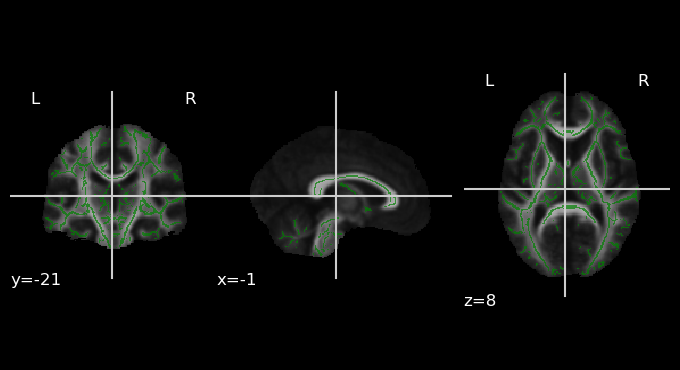

In [7]:
# Load the images
background_img = load_img(f"{tbss_dir}/stats/mean_FA.nii.gz")
overlay_img = load_img(f"{tbss_dir}/stats/mean_FA_skeleton.nii.gz")

#theshold the mean skeleton FA image to show only values between 0.2 and 1 for display purposes
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.2) & (data <= 1), 1, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho', interpolation='nearest')
display.add_overlay(thresholded_img, cmap=plt.cm.ocean, alpha=0.7, interpolation='nearest')  # Using 'ocean' colormap to display the skeleton in green 


# Show the plot
plt.show()

## Step 4 - Projecting all pre-aligned FA data onto the skeleton

The last TBSS script carries out the final steps necessary before you run the voxelwise cross-subject stats. It thresholds the mean FA skeleton image at the chosen threshold, typically 0.2. 

The thresholding creates a binary skeleton mask that defines the set of voxels used in all subsequent processing. 

Next a "distance map" is created from the skeleton mask. This is used in the projection of each subject's FA onto the skeleton; when searching outwards from a skeleton voxel for the local tract centre, the search only continues while the distance map values keep increasing - this means that the search knows to stop when it has got more than halfway between the starting skeleton point and another separate part of the skeleton.

Finally, the script takes the 4D pre-aligned FA images in all_FA and, for each "timepoint" (subject ID), projects the FA data onto the mean FA skeleton. This results in a 4D image file containing the (projected) skeletonised FA data. It is this file that you will feed into voxelwise statistics in the next step. 


In [8]:
#run tbss_4_prestats

#change to tbss directory
os.chdir(tbss_dir)

#check if the all_FA_skeletonised.nii.gz file exists within the tbss/stats directory, which would suggest that the tbss_4_prestats script has been run 
all_ske_file_path = f"{tbss_dir}/stats/all_FA_skeletonised.nii.gz"

#if the skeletonised data does not exist, run tbss_4_prestats
if not os.path.exists(all_ske_file_path):

    #set up the command
    command = f"module load fsl; tbss_4_prestats 0.2"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('tbss_4_prestats completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

## Step 5 - Voxelwise statistics on the skeletonised FA data

The previous steps resulted in the 4D all_FA_skeletonised.nii.gz file. It is this that you now feed into voxelwise statistics, that, for example, tells you which FA skeleton voxels are significantly different between two groups of subjects.

The recommended way of doing the stats is to use the randomise tool. For more detail see the Randomise manual https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide.

Before running randomise you will need to generate design matrix and contrast files (e.g., design.mat and design.con). Since we are only interested in the comparison between the two groups, with no covariates, we will use the design_ttest2 command to generate simple design mtrix and contrast files.


In [9]:
#change into the stats directory
os.chdir(f"{tbss_dir}/stats")

#creat the designa matrix and contrast files for comparing two groups of 10 pariticpants each 
command = f"module load fsl; design_ttest2 design 10 10"

# Execute the command
try:
    result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print('design_ttest2 completed successfully.')
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Output:\n", e.stdout)
    print("Errors:\n", e.stderr)

design_ttest2 completed successfully.


This step creates two files named design.mat and design.con. You are now ready to run the stats using randomise. TBSS developers recommend you should use --T2 option for TFCE instead of cluster-based thresholding for correction of multiple comparisons. Typically you would run 5000 permutations, but in the interest of time we will run just 500:

In [10]:
#change into the stats directory
os.chdir(f"{tbss_dir}/stats")

#check if the tbss_tfce_corrp_tstat1.nii.gz file exists within the tbss/stats directory, which would suggest that the randomise step has been run 
corrp_file_path = f"{tbss_dir}/stats/tbss_tfce_corrp_tstat1.nii.gz"

#if the skeletonised data does not exist, run randomise
if not os.path.exists(corrp_file_path):

    #set up the command to run randomise with 500 permutations
    command = (
        f'module load fsl/6.0.5; '
        f'randomise -i all_FA_skeletonised '
        f'-o tbss '
        f'-m mean_FA_skeleton_mask '
        f'-d design.mat '
        f'-t design.con '
        f'-n 500 '
        f'--T2 ' 
        f'-V'
    )

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('randomise completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

Contrast 1 gives the FA(old) > FA(young) test. The raw unthresholded tstat image is tbss_tstat1 and the corresponding (p-values corrected for multiple comparisons) cluster image is tbss_tfce_corrp_tstat1.

Thresholding clusters at 0.95 (corresponding to thresholding the p-values at 0.05, because randomise outputs p-values as 1-p for convenience of display - so that higher values are more significant). The following shows the corrected significant values in red-yellow:

/home/mc04/.conda/envs/fmri/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/home/mc04/.conda/envs/fmri/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


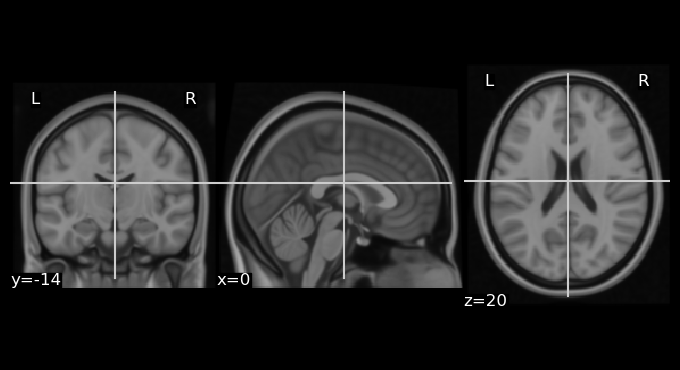

In [11]:
# Load the images
background_img = load_img(f"{fsldir_path}/data/standard/MNI152_T1_1mm.nii.gz")
overlay_img = load_img(f"{tbss_dir}/stats/tbss_tfce_corrp_tstat1.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant skeleton voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

# Show the plot
plt.show()

As you can see, there are no voxels in red or yellow. This is because there are no significant voxels for this comparison. This is not unexpected, since many studies have shown that FA generally decreases with age. 

Contrast 2 gives the FA(old) < FA(young) test, and the figure below shows the corrected significant values in green-blue:

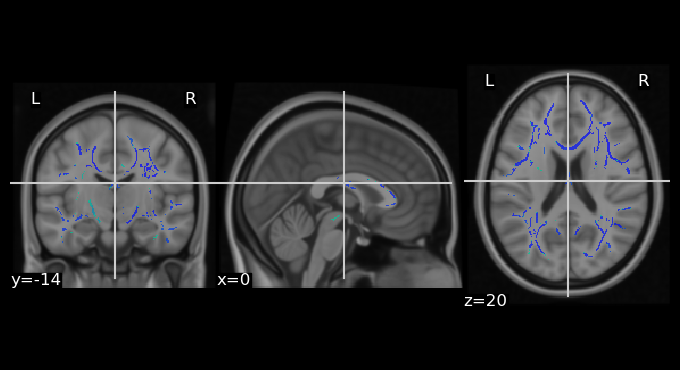

In [12]:
# Load the overlay image
overlay_img = load_img(f"{tbss_dir}/stats/tbss_tfce_corrp_tstat2.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant skeleton voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.winter_r, alpha=0.7)  # Using 'winter' colormap

# Show the plot
plt.show()

Our group analysis reveals widespread decline of FA with age, which is in line with previous reports in the Ageing literature. 

# Exercise

1. Investigate the impact of the skeleton threshold parameter specified in tbss_4_prestats.

In [37]:
#Exercise 1

#repeate tbss_4_prestats with a different threshold 

#change to tbss directory
os.chdir(tbss_dir)

#set up the command
command = f"module load fsl; tbss_4_prestats 0.01"

# Execute the command
try:
    result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print('tbss_4_prestats completed successfully.')
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Output:\n", e.stdout)
    print("Errors:\n", e.stderr)

tbss_4_prestats completed successfully.


In [38]:

#repeat the randomise step with the data generated with new threshold

#change to tbss directory
os.chdir(f"{tbss_dir}/stats")

#set up the command to run randomise with 500 permutations and remember to change the name of the output files to avoid overwriting the previous results
command = (
    f'module load fsl/6.0.5; '
    f'randomise -i all_FA_skeletonised '
    f'-o tbss_001 '
    f'-m mean_FA_skeleton_mask '
    f'-d design.mat '
    f'-t design.con '
    f'-n 500 '
    f'--T2 ' 
    f'-V'
)

# Execute the command
try:
    result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print('randomise completed successfully.')
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Output:\n", e.stdout)
    print("Errors:\n", e.stderr)

randomise completed successfully.


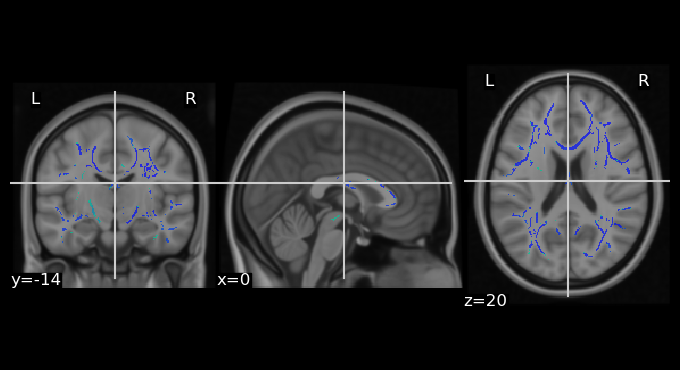

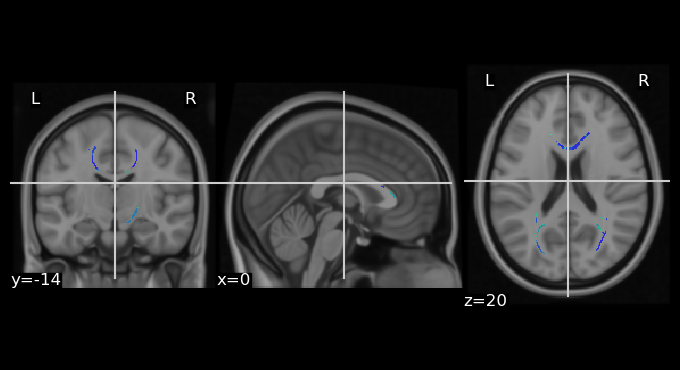

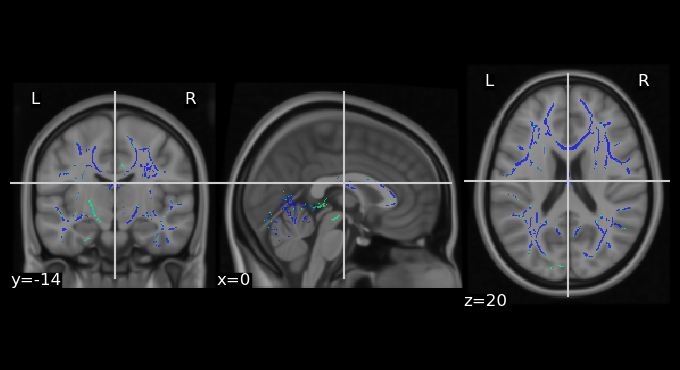

In [42]:
#compare the results of obtained with the two different thresholds

# Load the overlay significance map for threshold=0.2
overlay_img = load_img(f"{tbss_dir}/stats/tbss_tfce_corrp_tstat2.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant skeleton voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.winter_r, alpha=0.7)  # Using 'winter' colormap

#add a title to the plot
fig = plt.gcf()  # Get the current figure
fig.suptitle('Your Title Here', fontsize=16)

# Show the plot
plt.show()

# Load the overlay significance map for threshold=0.5
overlay_img = load_img(f"{tbss_dir}/stats/tbss_05_tfce_corrp_tstat2.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant skeleton voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display2 = plotting.plot_anat(background_img, display_mode='ortho')
display2.add_overlay(thresholded_img, cmap=plt.cm.winter_r, alpha=0.7)  # Using 'winter' colormap

# Show the plot
plt.show()

# Load the overlay significance map for threshold=0.5
overlay_img = load_img(f"{tbss_dir}/stats/tbss_001_tfce_corrp_tstat2.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant skeleton voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display3 = plotting.plot_anat(background_img, display_mode='ortho')
display3.add_overlay(thresholded_img, cmap=plt.cm.winter_r, alpha=0.7)  # Using 'winter' colormap

# Show the plot
plt.show()
